In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv('air_quality_train.csv')
data_test = pd.read_csv('air_quality_test.csv')

In [3]:
data_train.head(5)

,Unnamed: 0,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1)
0,0,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066
1,1,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282
2,2,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352
3,3,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190
4,4,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216


In [4]:
data_train.drop('Unnamed: 0', axis=1, inplace=True)
data_test.drop('Unnamed: 0', axis=1, inplace=True)

In [78]:
def series_to_supervised(data, in_lag=1, out_lag=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(in_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, out_lag):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names
    
    if dropnan:
        new_df.dropna(inplace=True)
    return new_df

# lag = 1

# Framing data test

In [6]:
data_test_framed = series_to_supervised(data_test)

In [7]:
data_test_framed.drop(data_test_framed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)
data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t)
1,0.059322,0.123475,0.028302,0.105407,0.075829,0.347310,0.245562,0.116007,0.117724,0.286022,0.286792,0.120364,0.121536
2,0.050847,0.133525,0.029874,0.109776,0.071090,0.348158,0.230769,0.121403,0.105126,0.283871,0.293082,0.121536,0.121390
3,0.084746,0.165111,0.042453,0.141453,0.117806,0.302838,0.325444,0.138489,0.149435,0.277419,0.299371,0.121390,0.123638
4,0.084746,0.175879,0.050314,0.155653,0.120515,0.294367,0.352071,0.144335,0.178540,0.262366,0.324528,0.123638,0.131701
5,0.093220,0.180905,0.051887,0.158930,0.142180,0.288014,0.384615,0.153777,0.204170,0.221505,0.398742,0.131701,0.116356


In [8]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t)']]

In [9]:
x_validation = np.expand_dims(x_validation, axis=2)

In [10]:
data_train_framed = series_to_supervised(data_train)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,...,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,...,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,...,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,...,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,...,0.072327,0.200437,0.058903,0.429903,0.278107,0.378597,0.316247,0.281720,0.628931,0.293261


# Framing data train

In [11]:
data_train_framed.drop(data_train_framed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.264282
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.276352
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.294190
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.295216
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.293261


In [12]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t)']]

In [13]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    
    return x_train, x_test, y_train, y_test

In [14]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [15]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5986, 12) (1497, 12) (5986, 1) (1497, 1)


In [16]:
model = Sequential()

model.add(Conv1D(filters=10, kernel_size=2, activation='relu', input_shape=(12, 1)))
model.add(Conv1D(filters=10, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

W0710 04:52:42.064722 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 04:52:42.079918 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 04:52:42.083372 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 04:52:42.130077 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [17]:
model.compile(optimizer='adam', loss='mse')

W0710 04:52:46.670884 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Test and validation with 100 epochs

In [18]:
x = np.expand_dims(x, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [19]:
print(x.shape, x_test.shape)

(7483, 12, 1) (1497, 12, 1)


In [20]:
model.fit(x, y, epochs=100, verbose=0)

W0710 04:52:50.818813 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0710 04:52:50.954811 139732819654272 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [21]:
prediction = model.predict(x_test)

In [22]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.0215


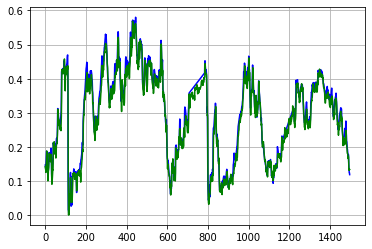

In [23]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [24]:
validation = model.predict(x_validation)

In [25]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.02032


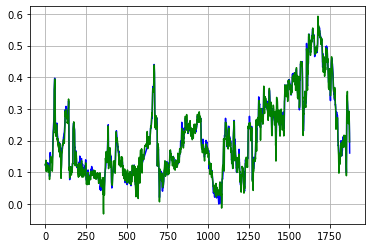

In [26]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 500 epochs

In [27]:
model.fit(x, y, epochs=500, verbose=0)

In [28]:
prediction = model.predict(x_test)

In [29]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.02341


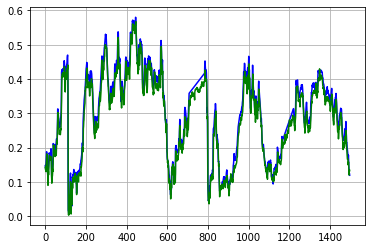

In [30]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [31]:
validation = model.predict(x_validation)

In [32]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.031


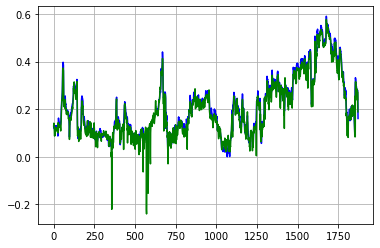

In [33]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 1000 epochs

In [34]:
model.fit(x, y, epochs=1000, verbose=0)

In [35]:
prediction = model.predict(x_test)

In [36]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.01473


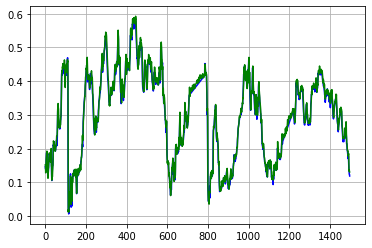

In [37]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [38]:
validation = model.predict(x_validation)

In [39]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.03153


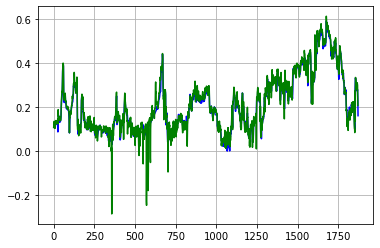

In [40]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# lag = 5

In [41]:
data_train_framed = series_to_supervised(data_train, out_lag=5)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4),var9(t+4),var10(t+4),var11(t+4),var12(t+4)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,...,0.072327,0.200437,0.058903,0.429903,0.278107,0.378597,0.316247,0.281720,0.628931,0.293261
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,...,0.055031,0.167668,0.040623,0.482846,0.221893,0.351619,0.222415,0.283871,0.598742,0.281288
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,...,0.050314,0.157837,0.040623,0.479034,0.218935,0.351619,0.221112,0.270968,0.638994,0.286126
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,...,0.034591,0.123430,0.029113,0.532402,0.171598,0.325989,0.173328,0.270968,0.635220,0.283487
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,...,0.025157,0.097215,0.020988,0.585769,0.133136,0.307554,0.121633,0.262366,0.641509,0.277085


In [42]:
data_train_framed.drop(data_train_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
]], axis=1, inplace=True)

In [43]:
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+4)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.293261
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.281288
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.286126
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.283487
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.277085


In [44]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t+4)']]

In [45]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [46]:
x = np.expand_dims(x, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [47]:
data_test_framed = series_to_supervised(data=data_test, out_lag=5)

In [48]:
data_test_framed.drop(data_test_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
]], axis=1, inplace=True)

In [49]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t+4)']]

In [50]:
x_validation = np.expand_dims(x_validation, axis=2)

# Test and validation with 100 epochs

In [51]:
model.fit(x, y, epochs=100, verbose=0)

In [52]:
prediction = model.predict(x_test)

In [53]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.04068


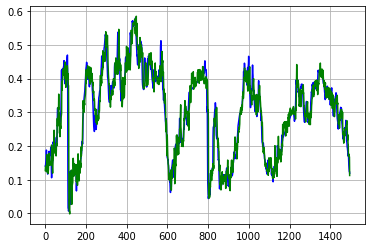

In [54]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [55]:
validation = model.predict(x_validation)

In [56]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05229


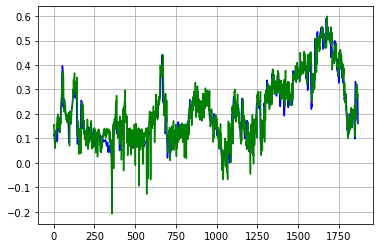

In [57]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 500 epochs

In [58]:
model.fit(x, y, epochs=500, verbose=0)

In [59]:
prediction = model.predict(x_test)

In [60]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03979


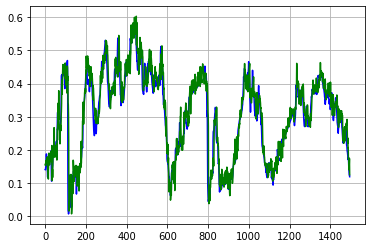

In [61]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [62]:
validation = model.predict(x_validation)

In [63]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06665


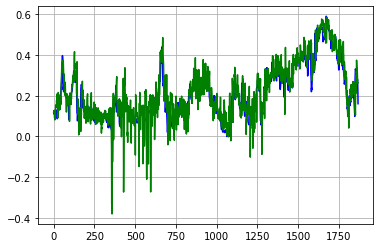

In [64]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 1000 epochs

In [65]:
model.fit(x, y, epochs=1000, verbose=0)

In [66]:
prediction = model.predict(x_test)

In [67]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.03651


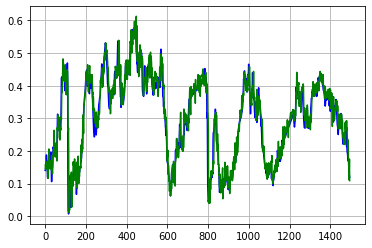

In [68]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [69]:
validation = model.predict(x_validation)

In [70]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06849


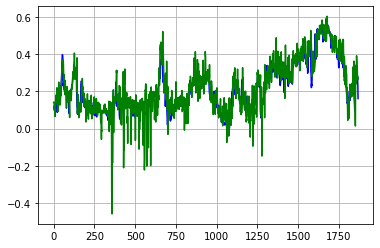

In [71]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# lag = 10

In [72]:
data_train_framed = series_to_supervised(data_train, out_lag=10)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9),var9(t+9),var10(t+9),var11(t+9),var12(t+9)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,...,0.018868,0.078646,0.012864,0.633630,0.094675,0.290468,0.097307,0.258065,0.645283,0.274544
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,...,0.015723,0.070453,0.009479,0.675985,0.076923,0.283723,0.087315,0.277419,0.591195,0.269706
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,...,0.023585,0.092845,0.021666,0.599746,0.136095,0.301259,0.109036,0.266667,0.615094,0.269071
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,...,0.048742,0.155106,0.064997,0.494706,0.236686,0.354317,0.221112,0.260215,0.633962,0.272199
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,...,0.124214,0.282359,0.116452,0.344769,0.325444,0.434353,0.382711,0.273118,0.606289,0.271759


In [73]:
data_train_framed.drop(data_train_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,
    72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,
    92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,
    109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,
    124,125,126,127,128,129,130
]], axis=1, inplace=True)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+9)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.274544
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.269706
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.269071
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.272199
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.271759


In [74]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t+9)']]

In [75]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [76]:
x = np.expand_dims(x, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [80]:
data_test_framed = series_to_supervised(data=data_test, out_lag=10)

In [81]:
data_test_framed.drop(data_test_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,
    72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,
    92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,
    109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,
    124,125,126,127,128,129,130
]], axis=1, inplace=True)
data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+9)
1,0.059322,0.123475,0.028302,0.105407,0.075829,0.347310,0.245562,0.116007,0.117724,0.286022,0.286792,0.120364,0.118898
2,0.050847,0.133525,0.029874,0.109776,0.071090,0.348158,0.230769,0.121403,0.105126,0.283871,0.293082,0.121536,0.122269
3,0.084746,0.165111,0.042453,0.141453,0.117806,0.302838,0.325444,0.138489,0.149435,0.277419,0.299371,0.121390,0.128867
4,0.084746,0.175879,0.050314,0.155653,0.120515,0.294367,0.352071,0.144335,0.178540,0.262366,0.324528,0.123638,0.127401
5,0.093220,0.180905,0.051887,0.158930,0.142180,0.288014,0.384615,0.153777,0.204170,0.221505,0.398742,0.131701,0.129111


In [82]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t+9)']]

In [83]:
x_validation = np.expand_dims(x_validation, axis=2)

# Test and validation with 100 epochs

In [84]:
model.fit(x, y, epochs=100, verbose=0)

In [85]:
prediction = model.predict(x_test)

In [86]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.05519


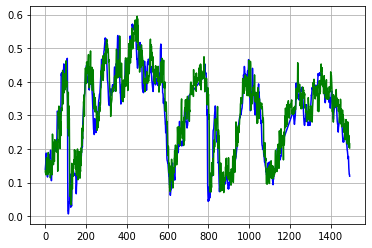

In [87]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [88]:
validation = model.predict(x_validation)

In [89]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.07776


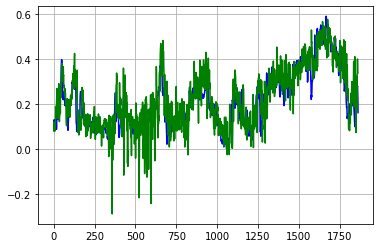

In [90]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 500 epochs

In [91]:
model.fit(x, y, epochs=500, verbose=0)

In [92]:
prediction = model.predict(x_test)

In [93]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.04866


In [94]:
validation = model.predict(x_validation)

In [95]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.09179


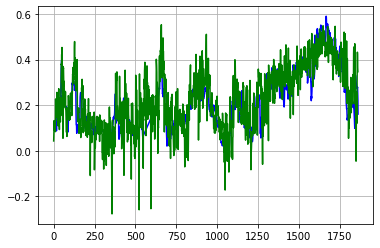

In [96]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 1000 epochs

In [97]:
model.fit(x, y, epochs=1000, verbose=0)

In [98]:
prediction = model.predict(x_test)

In [99]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.04458


In [100]:
validation = model.predict(x_validation)

In [101]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.12702


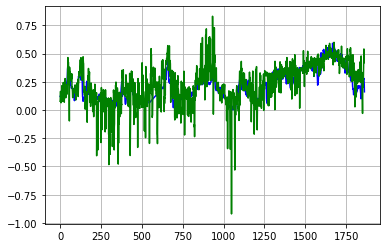

In [102]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)